In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
fair_temperatures_low = xr.open_dataset("../data/outputs/temperature_low_emissions.nc").to_array().isel(variable=0)
fair_temperatures_med = xr.open_dataset("../data/outputs/temperature_medium_emissions.nc").to_array().isel(variable=0)
fair_temperatures_high = xr.open_dataset("../data/outputs/temperature_high_emissions.nc").to_array().isel(variable=0)
fair_temperatures=fair_temperatures_low

In [3]:
ds_timebounds = pd.read_csv("../data/outputs/timebounds.csv")
timebounds=ds_timebounds['0'].values

# Make figures

In [4]:
baseline_scenario = 'low'

scenarios = [
    baseline_scenario,
  "instant-removal-offsetting",
 "physical-delay-offsetting",
 "accelerated-emissions-offsetting",
    "upfront-embodied-offsetting",
]

fancy_titles = {
    'low': 'Baseline',
    "medium-extension": 'Baseline',
    "high-extension": 'Baseline',
    "instant-removal-offsetting":"Instant Removal",
    "physical-delay-offsetting":"Physical Delay",
    "accelerated-emissions-offsetting":"Accelerated Emissions",
    "upfront-embodied-offsetting":"Upfront Emissions",
}

colors = {
    'low': 'black',
    "medium-extension": 'black',
    "high-extension": 'black',
    "instant-removal-offsetting":"green",
    "physical-delay-offsetting":"blue",
    "accelerated-emissions-offsetting":"red",
    "upfront-embodied-offsetting":"purple",
}

linestyles = {
    'low': '-',
    "medium-extension": '-',
    "high-extension": '-',
    "instant-removal-offsetting":"--",
    "physical-delay-offsetting":"-",
    "accelerated-emissions-offsetting":"-",
    "upfront-embodied-offsetting":"--",
}

In [5]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

### Difference from baseline

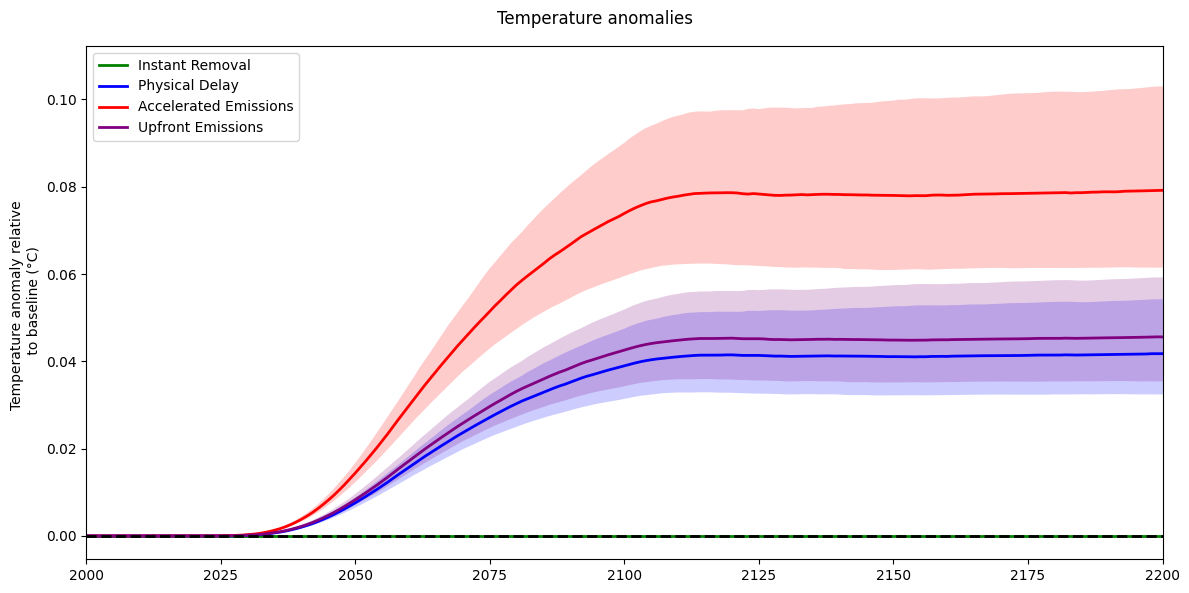

In [6]:
fig= plt.figure(figsize=(12, 6))

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for i, scenario in enumerate(scenarios_to_plot):
    plt.fill_between(
        timebounds,
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
            pp[0],
            axis=1,
        ),
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
            pp[1],
            axis=1,
        ),
        color=colors[scenario],
        alpha=0.2,
        lw=0
    )

    plt.plot(
        timebounds,
        np.median(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
            axis=1,
        ),
        color=colors[scenarios_to_plot[i]],label=fancy_titles[scenarios_to_plot[i]],
        lw=2
    )
plt.xlim(2000, 2200)
plt.legend()
plt.suptitle("Temperature anomalies")
plt.axhline(y=0, color="k", ls="--", lw=2, label='Baseline')
plt.ylabel('Temperature anomaly relative \n to baseline (°C)')
fig.tight_layout()


### Scenario trajectories

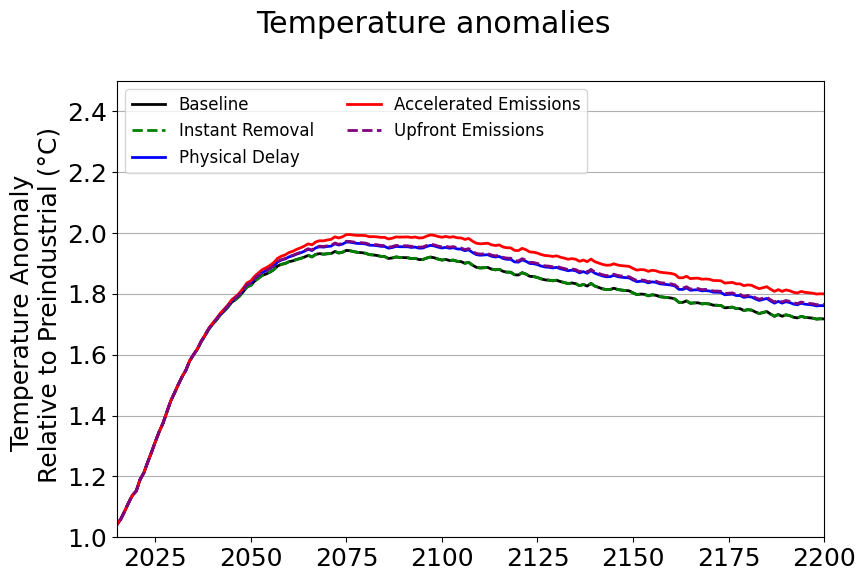

In [11]:
ncols=3
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(9, 6))

for i, scenario in enumerate(scenarios):
    if scenario=='low':
        timebounds_start=0
    else:
        timebounds_start=250
    linewidth=2
    alpha=1
    plt.plot(
        timebounds[timebounds_start:],
        np.mean(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )[timebounds_start:],
        color=colors[scenario],
        linestyle=linestyles[scenario],
        label=fancy_titles[scenario],
        linewidth=linewidth,
        alpha=alpha
    )
plt.xlim([2015, 2200])
plt.ylim([1.0, 2.5])
plt.axhline(0, color="k", ls=":", lw=0.5)
plt.legend(fontsize=12, loc='upper left', ncols=2)
plt.grid(axis='y')
plt.ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()
plt.savefig('../figures/Temperature_anomalies_v2.pdf')

# Peak temperatures

In [8]:
peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
peak_temperatures.to_csv('../data/outputs/peak_temperatures.csv')

Text(0.5, 0, 'Peak Temperature')

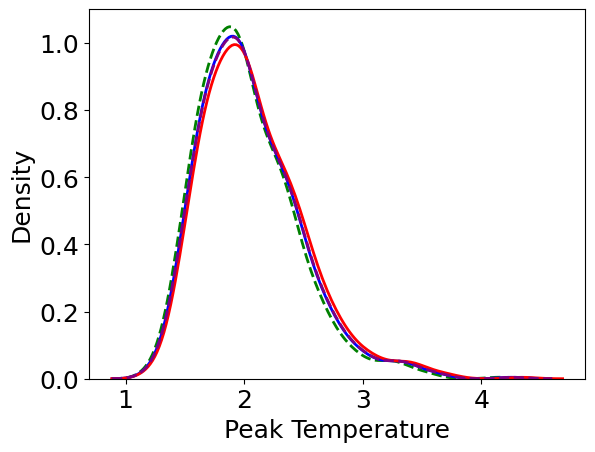

In [9]:
for i,scenario in enumerate(scenarios_to_plot):
    sns.kdeplot(peak_temperatures[scenario], 
                bw_adjust=1,
                color=colors[scenario],
                label=scenario, 
                lw=2,linestyle=linestyles[scenario])
#plt.xlim([0.75,4])
plt.xlabel('Peak Temperature')

/tmp/ipykernel_34787/2456148457.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,


Text(0.5, 0, 'Change in Peak Temperature (relative to baseline')

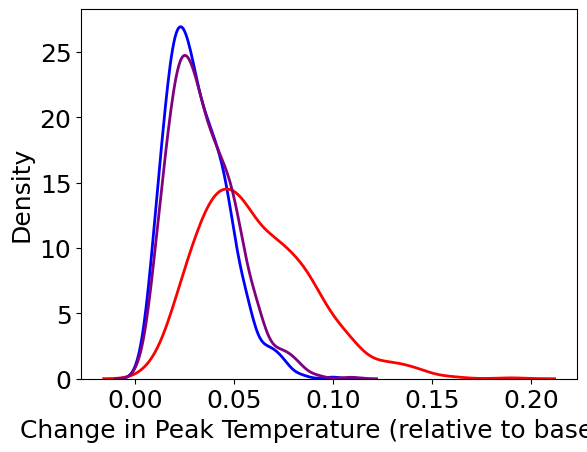

In [10]:
for i,scenario in enumerate(scenarios_to_plot):
    peak_temp_diff = (peak_temperatures[scenario]-
                      peak_temperatures[baseline_scenario])
    sns.kdeplot(peak_temp_diff, 
                bw_adjust=1,
                color=colors[scenario],
                label=scenario, 
                lw=2,linestyle='-')
plt.xlabel('Change in Peak Temperature (relative to baseline')

# Comparing SSPs

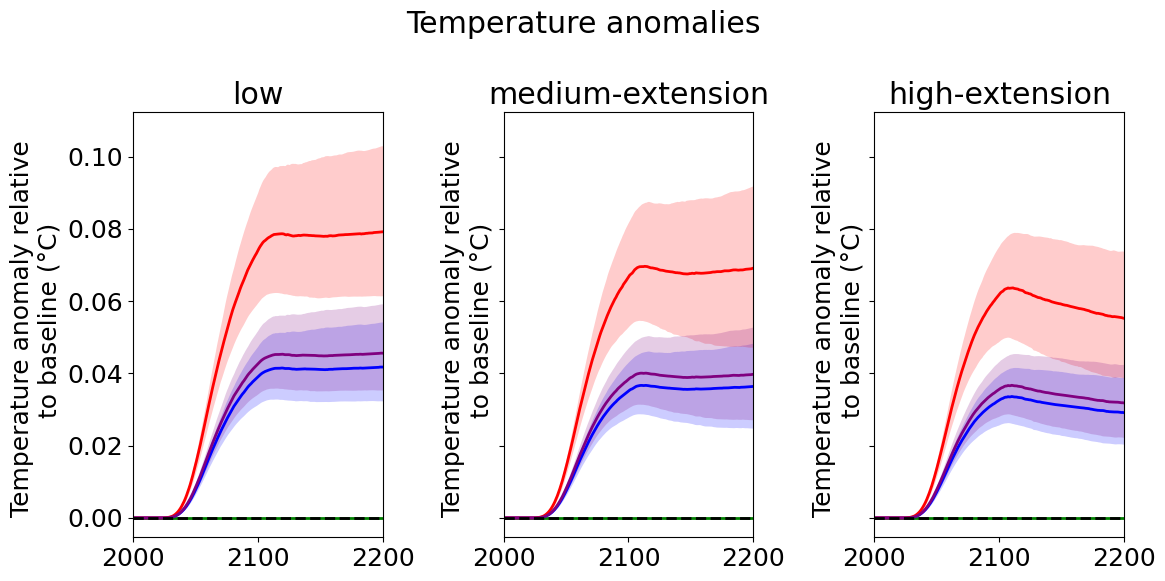

In [16]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    for i, scenario in enumerate(scenarios_to_plot):
        ax.fill_between(
            timebounds,
            np.percentile(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                pp[1],
                axis=1,
            ),
            color=colors[scenario],
            alpha=0.2,
            lw=0
        )
    
        ax.plot(
            timebounds,
            np.median(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                axis=1,
            ),
            color=colors[scenarios_to_plot[i]],label=fancy_titles[scenarios_to_plot[i]],
            lw=2
        )
    ax.set_xlim(2000, 2200)
    #ax.legend()
    ax.set_title(baseline_scenario)
    ax.axhline(y=0, color="k", ls="--", lw=2, label='Baseline')
    ax.set_ylabel('Temperature anomaly relative \n to baseline (°C)')
plt.suptitle("Temperature anomalies")
fig.tight_layout()


/tmp/ipykernel_34787/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,
/tmp/ipykernel_34787/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,
/tmp/ipykernel_34787/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,


Text(0.5, 59.7222222222222, 'Change in Peak Temperature (relative to baseline')

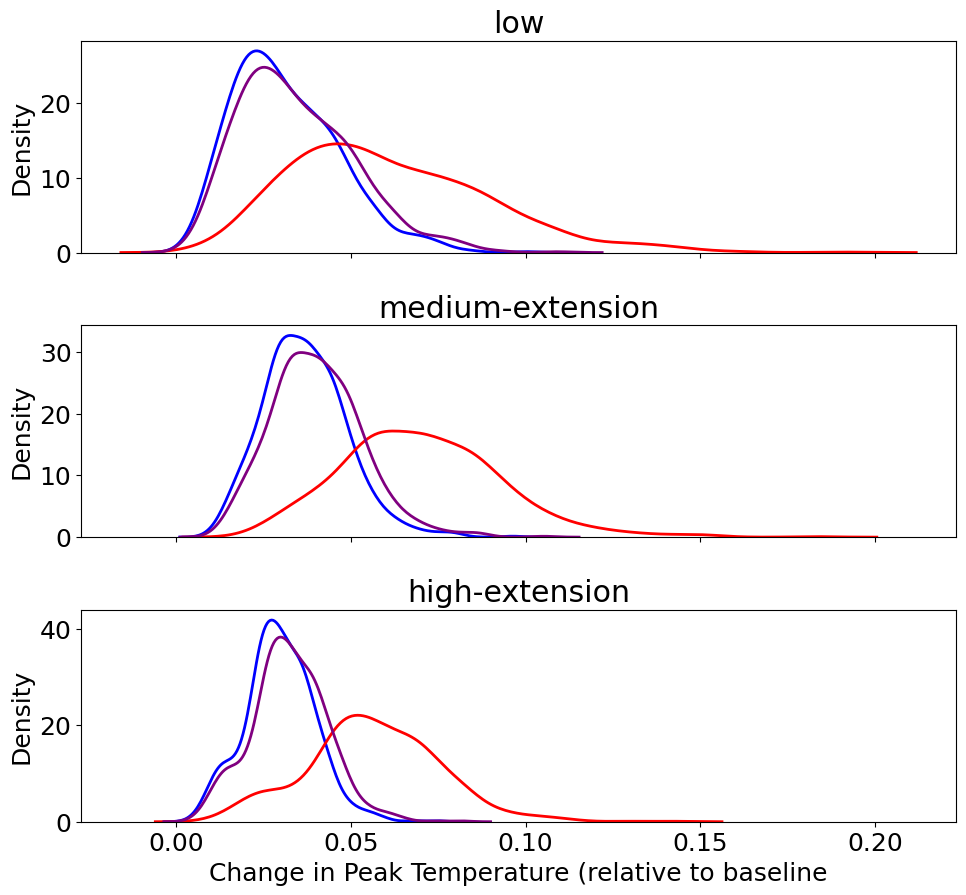

In [23]:
fig, axes= plt.subplots(nrows=3, ncols=1, figsize=(10, 9), sharex=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
    for i,scenario in enumerate(scenarios_to_plot):
        peak_temp_diff = (peak_temperatures[scenario]-
                          peak_temperatures[baseline_scenario])
        sns.kdeplot(peak_temp_diff, 
                    bw_adjust=1,
                    color=colors[scenario],
                    label=scenario, 
                    lw=2,linestyle='-',ax=ax)
    ax.set_title(baseline_scenario)
    ax.set_label('Change in Peak Temperature (relative to baseline')
plt.tight_layout()
ax.set_xlabel('Change in Peak Temperature (relative to baseline')

In [24]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    for i, scenario in enumerate(scenarios):
    if scenario=='low':
        timebounds_start=0
    else:
        timebounds_start=250
    linewidth=2
    alpha=1
    plt.plot(
        timebounds[timebounds_start:],
        np.mean(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )[timebounds_start:],
        color=colors[scenario],
        linestyle=linestyles[scenario],
        label=fancy_titles[scenario],
        linewidth=linewidth,
        alpha=alpha
    )
    ax.set_xlim([2015, 2200])
    ax.axhline(0, color="k", ls=":", lw=0.5)
    ax.legend(fontsize=12, loc='upper left', ncols=2)
    ax.grid(axis='y')
    ax.set_ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()

IndentationError: expected an indented block after 'for' statement on line 19 (792435138.py, line 20)

# Scraps

/tmp/ipykernel_10691/3991577249.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(peak_temperatures, labels=peak_temperatures.columns)


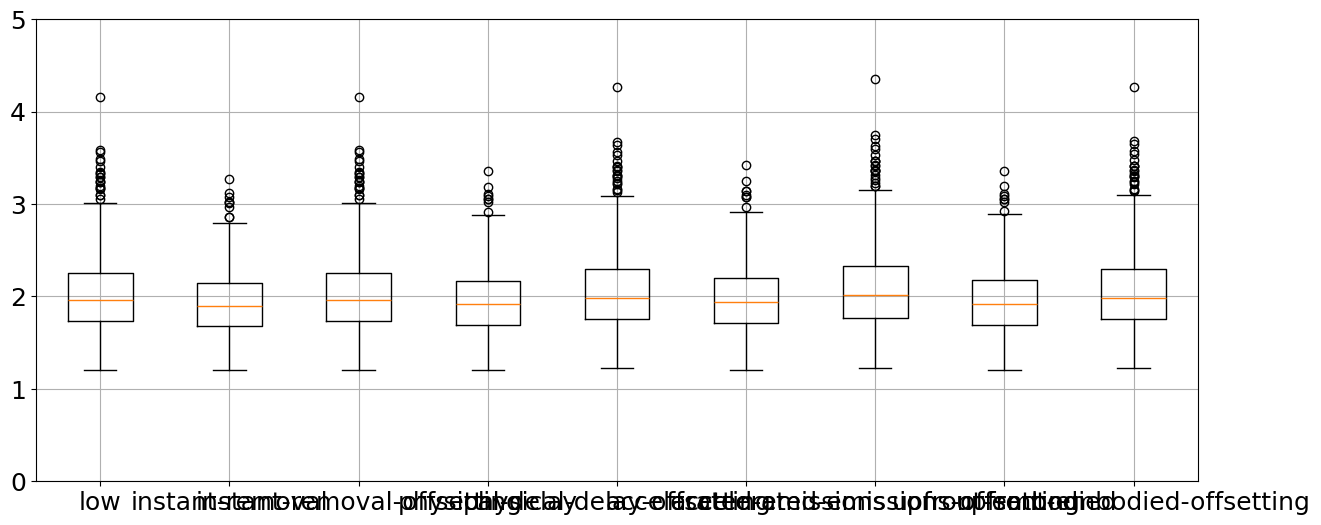

In [54]:
plt.figure(figsize=(15,6))
plt.boxplot(peak_temperatures, labels=peak_temperatures.columns)
plt.ylim([0,5])
plt.grid()

In [55]:
# New order of columns


n_boxes = len(peak_temperatures.columns)
positions = np.arange(n_boxes) * 0.15  # smaller step = closer together

bp = plt.boxplot(
    peak_temperatures,
    widths=0.1,
    patch_artist=True,
    positions=positions,
    boxprops=dict(linewidth=0.5, color='black'),
    whiskerprops=dict(linewidth=0.25),#dict(linewidth=0.5, color='black'),
    capprops=dict(linewidth=0.5, color='black'),
    medianprops=dict(linewidth=0.5, color='black'),
    showfliers=True,
    showmeans=False,
)

i=0
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    if hatches[i]=='':
        patch.set(facecolor=color, edgecolor='black',alpha=alphas[i],hatch=hatches[i])
    else:
        patch.set(facecolor='white', edgecolor=color,alpha=alphas[i],hatch=hatches[i])
        
    i=i+1
#plt.ylim([1.0, 2.5])
plt.savefig('../figures/Peak_temperature.pdf')

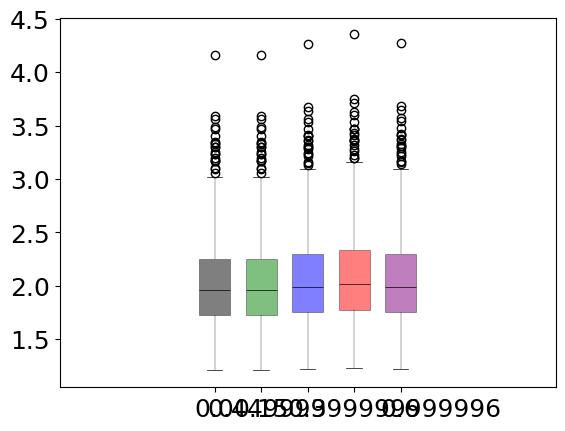

In [25]:
# New order of columns
new_order = ['low',  'instant-removal-offsetting',
             'physical-delay-offsetting', 
             'accelerated-emissions-offsetting',
             'upfront-embodied-offsetting',
       ]

# Reorder the DataFrame
peak_temperatures = peak_temperatures[new_order]

colors = ['black','green','blue','red','purple','green','blue','red','purple',]
alphas=[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
hatches = ['', '','','','']

n_boxes = len(peak_temperatures.columns)
positions = np.arange(n_boxes) * 0.15  # smaller step = closer together

bp = plt.boxplot(
    peak_temperatures,
    widths=0.1,
    patch_artist=True,
    positions=positions,
    boxprops=dict(linewidth=0.5, color='black'),
    whiskerprops=dict(linewidth=0.25),#dict(linewidth=0.5, color='black'),
    capprops=dict(linewidth=0.5, color='black'),
    medianprops=dict(linewidth=0.5, color='black'),
    showfliers=True,
    showmeans=False,
)

i=0
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    if hatches[i]=='':
        patch.set(facecolor=color, edgecolor='black',alpha=alphas[i],hatch=hatches[i])
    else:
        patch.set(facecolor='white', edgecolor=color,alpha=alphas[i],hatch=hatches[i])
        
    i=i+1
#plt.ylim([1.0, 2.5])
plt.savefig('../figures/Peak_temperature.pdf')

Text(0.5, 0, 'Peak Temperature')

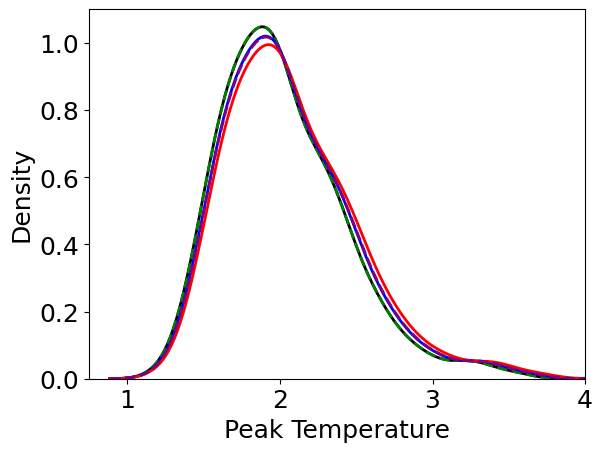

<Axes: xlabel='scenario'>

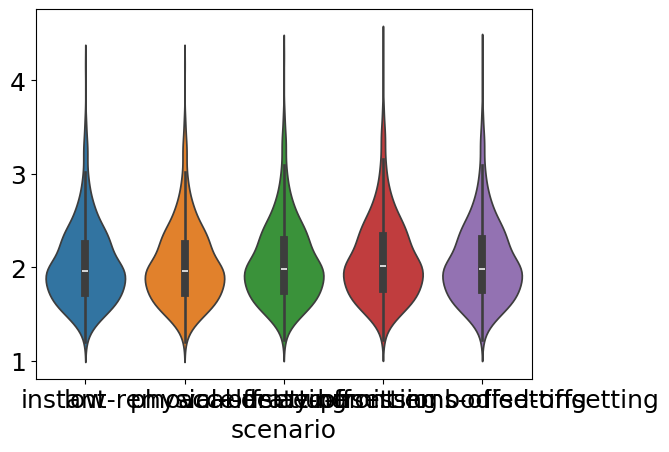

In [52]:
sns.violinplot(peak_temperatures)

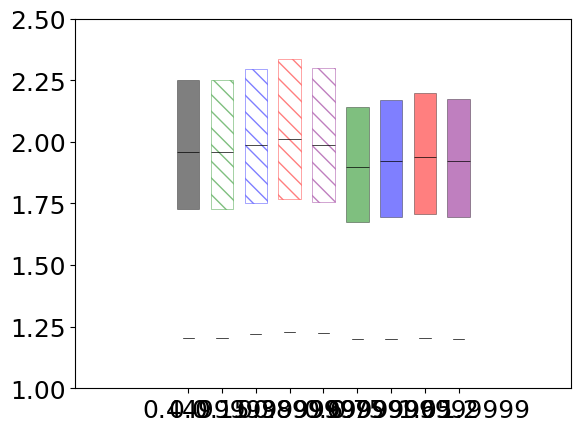

In [58]:
n_boxes = len(peak_temperatures.columns)
positions = np.arange(n_boxes) * 0.15  # smaller step = closer together

bp = plt.boxplot(
    peak_temperatures,
    widths=0.1,
    patch_artist=True,
    positions=positions,
    boxprops=dict(linewidth=0.5, color='black'),
    whiskerprops=dict(linewidth=0),#dict(linewidth=0.5, color='black'),
    capprops=dict(linewidth=0.5, color='black'),
    medianprops=dict(linewidth=0.5, color='black'),
    showfliers=False,
    showmeans=False,
)

i=0
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    if hatches[i]=='':
        patch.set(facecolor=color, edgecolor='black',alpha=alphas[i],hatch=hatches[i])
    else:
        patch.set(facecolor='white', edgecolor=color,alpha=alphas[i],hatch=hatches[i])
        
    i=i+1
plt.ylim([1.0, 2.5])
plt.savefig('../figures/Peak_temperature.pdf')